# BTC CLOSE PRICE FORECAST

### MAIN GOAL - forecast direction of BTC Close price

#### Used data - top 6 crypto cryptocurrencies according to market cap and USDT :
1. BTC  (Volume)
2. BCH  (Close Price & Volume)
3. EOS  (Close Price & Volume)
4. ETC  (Close Price & Volume)
5. ETH  (Close Price & Volume)
6. LTC  (Close Price & Volume)
7. USDT (Close Price & Volume)

Import libraries

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy
from scipy.stats import jarque_bera, kstest
from statsmodels.api import OLS
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import acf
from statsmodels.tools.eval_measures import rmse, stde
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

warnings.filterwarnings("ignore")

Functions for tests and charts

In [2]:
def normality_tests(x):
    sns.distplot(x)
    print("Jarque-Bera test:\n stat=%.5f, p-value=%.5f\n" % jarque_bera(x))
    print("K-S test:\n stat=%.5f, p-value=%.5f" % kstest(x, "norm"))

def autocorrelation_tests(ser, nlags=40):
    ar, q, p = acf(ser, qstat=True, nlags=nlags)
    table = pd.DataFrame(np.stack([ar[1:], q, p], axis=-1), columns=["AC", "Q", "P-value"])
    table.index = range(1, len(table) + 1)
    table.index.name = "Lag"
    return table

def plot_autocorr(ser):
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(211)
    fig = plot_acf(ser, lags=range(1, 36), ax=ax)
    ax = fig.add_subplot(212)
    fig = plot_pacf(ser, lags=range(1, 36), ax=ax)

Data set is consists of 5 years times series realization. Simple preprocessing was made, such as removing empty observations. Total length of data set is 1031 observations per each variable.

In [3]:
data_info = {
    "btc": "data/BTC-USD.csv",
    "bch": "data/BCH-USD.csv",
    "eos": "data/EOS-USD.csv",
    "etc": "data/ETC-USD.csv",
    "eth": "data/ETH-USD.csv",
    "ltc": "data/LTC-USD.csv",
    "usdt": "data/USDT-USD.csv"
}

<class 'pandas.core.frame.DataFrame'>
Index: 1031 entries, 2017-07-23 to 2020-05-18
Data columns (total 14 columns):
Close_btc      1031 non-null float64
Volume_btc     1031 non-null int64
Close_bch      1031 non-null float64
Volume_bch     1031 non-null float64
Close_eos      1031 non-null float64
Volume_eos     1031 non-null float64
Close_etc      1031 non-null float64
Volume_etc     1031 non-null float64
Close_eth      1031 non-null float64
Volume_eth     1031 non-null float64
Close_ltc      1031 non-null float64
Volume_ltc     1031 non-null int64
Close_usdt     1031 non-null float64
Volume_usdt    1031 non-null int64
dtypes: float64(11), int64(3)
memory usage: 120.8+ KB
None


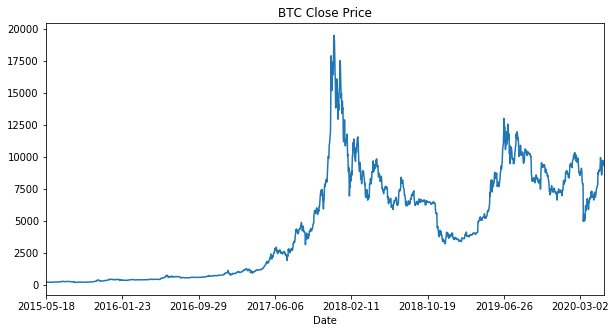

In [4]:
df = None
for ticker in data_info:
    tmp_df = pd.read_csv(
        data_info[ticker],
        index_col="Date",
        usecols=["Date", "Close", "Volume"]
    ).add_suffix("_" + ticker)
    df = tmp_df if df is None else df.join(tmp_df, how="outer")

btc_price = deepcopy(df["Close_btc"])
df.dropna(inplace=True, axis=0)

plt.figure(figsize=(10, 5))
btc_price.plot()
plt.title("BTC Close Price")
print(df.info())

In [5]:
df.describe(include="all")

,Close_btc,Volume_btc,Close_bch,Volume_bch,Close_eos,Volume_eos,Close_etc,Volume_etc,Close_eth,Volume_eth,Close_ltc,Volume_ltc,Close_usdt,Volume_usdt
count,1031.000000,1.031000e+03,1031.000000,1.031000e+03,1031.000000,1.031000e+03,1031.000000,1.031000e+03,1031.000000,1.031000e+03,1031.000000,1.031000e+03,1031.000000,1.031000e+03
mean,7507.359933,1.394750e+10,577.876125,1.447586e+09,5.013832,1.488956e+09,11.589931,5.728641e+08,318.633076,5.671410e+09,83.310874,1.824955e+09,1.002635,1.385259e+10
std,2835.439526,1.258287e+10,543.004311,1.767162e+09,3.487714,1.308398e+09,8.276992,6.482059e+08,236.070443,5.499766e+09,54.746831,1.717478e+09,0.007641,1.688624e+10
min,2529.449951,7.059430e+08,77.365776,8.501300e+04,0.493225,4.556540e+06,3.472387,1.799190e+07,84.308296,2.537470e+08,23.464329,5.178620e+07,0.966644,5.724270e+07
25%,5598.099853,4.634520e+09,239.191368,3.615825e+08,2.659600,5.521720e+08,5.219918,1.641345e+08,168.564514,1.681095e+09,48.669196,3.426250e+08,0.999515,2.375105e+09
50%,7321.988281,8.853000e+09,381.523529,9.651510e+08,4.045654,1.182881e+09,9.006710,3.549500e+08,222.669724,3.290080e+09,61.514400,9.408250e+08,1.001940,4.137240e+09
75%,9172.725097,1.950908e+10,691.756501,1.845514e+09,6.188033,2.163006e+09,15.204650,6.826391e+08,380.378997,7.899849e+09,96.880074,3.093570e+09,1.005272,2.106422e+10
max,19497.400391,7.415677e+10,3923.070068,2.957459e+10,21.542601,1.001470e+10,44.047501,4.699240e+09,1396.420044,2.808919e+10,358.335999,7.552238e+09,1.077880,9.931533e+10


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002AD0C7936C8>],
      dtype=object)

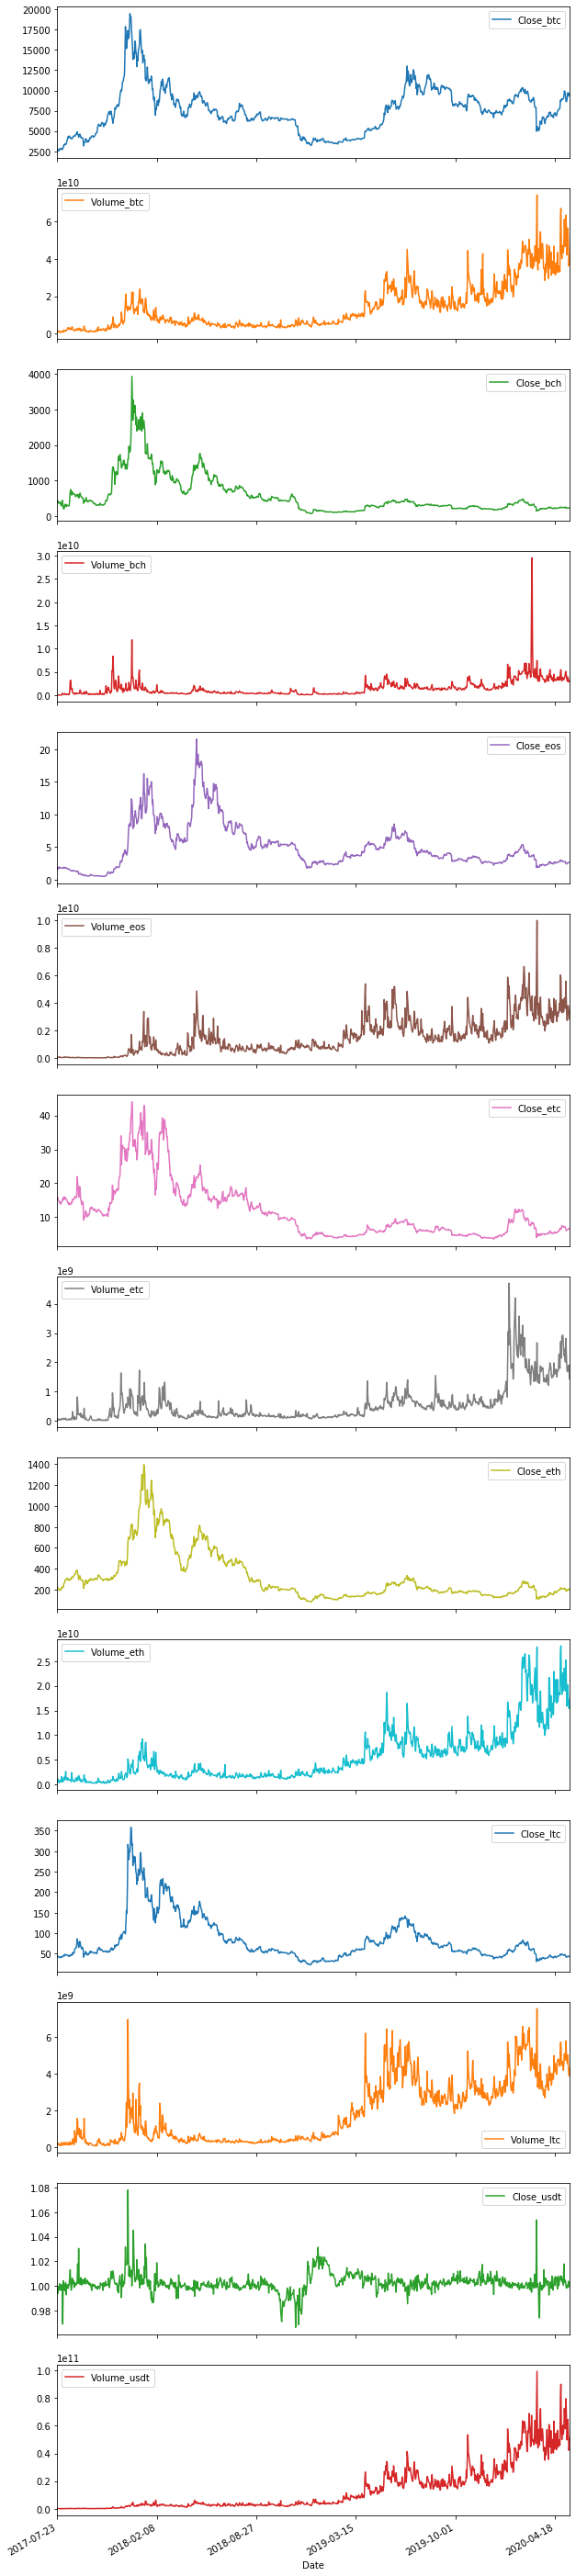

In [6]:
df.plot(subplots=True, layout=(20, 1), figsize=(10, 80))

From charts above we can see that all processes are nonstationary:
\begin{equation*}
E(x_t)= \mu_t\\
D(x_t)= \sigma_t^2\\
\end{equation*}
To solve this issue we should use logarithmic growth rates for volume and logarithmic returns for prices:
\begin{equation*}
r_t = \ln{\frac{x_t}{x_{ t-1}}}
\end{equation*}

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002AD0DE56308>],
      dtype=object)

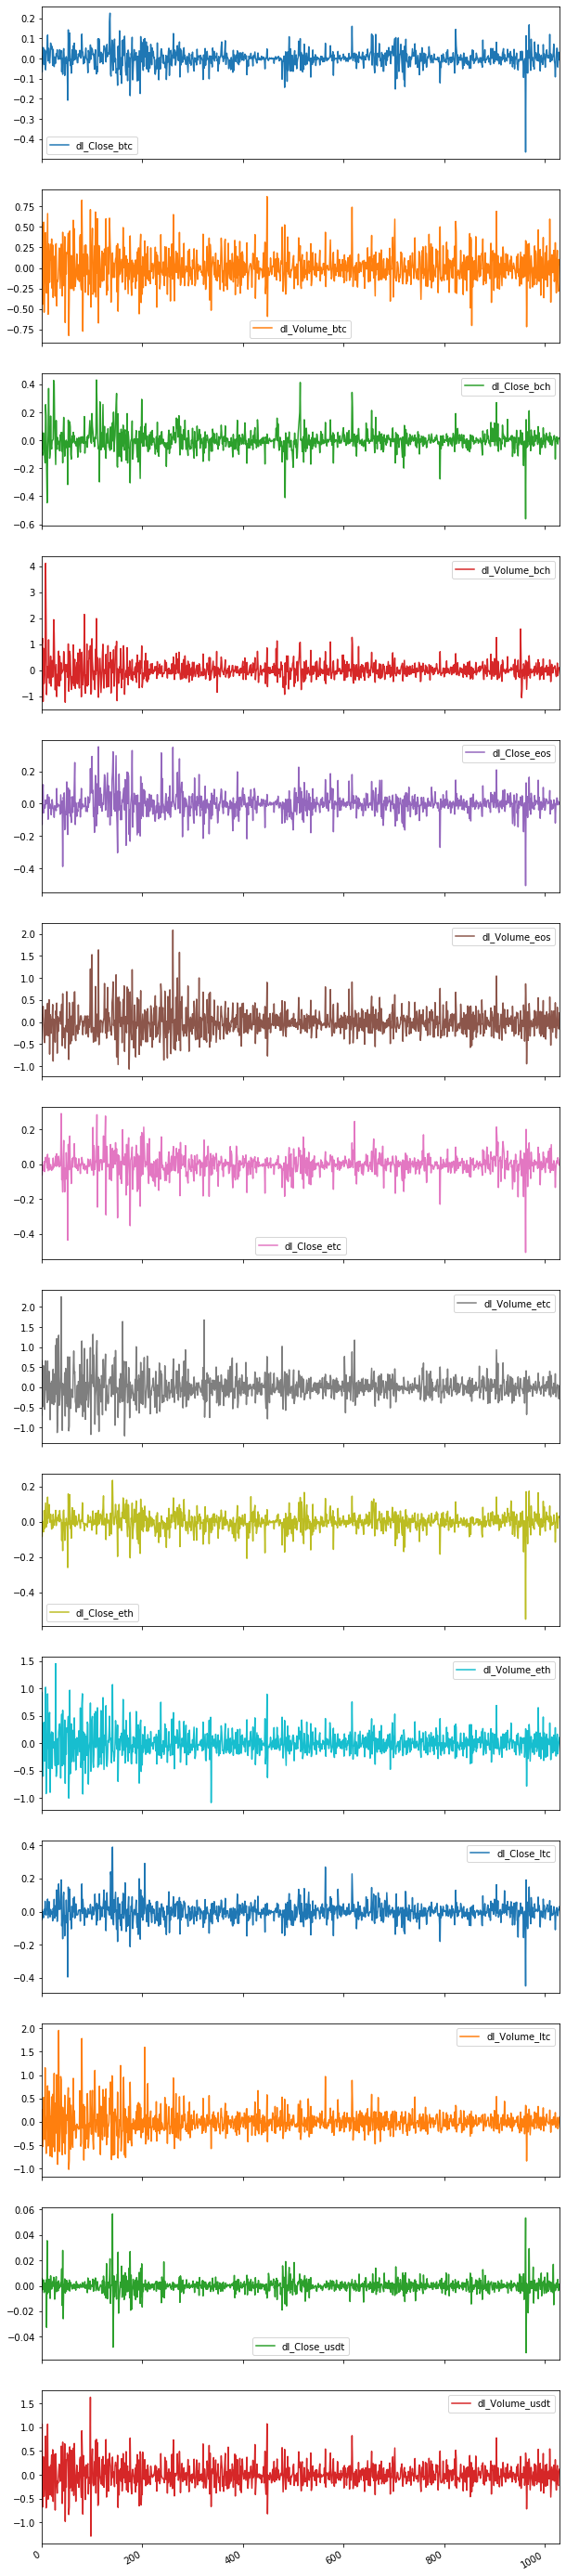

In [7]:
r_df = pd.DataFrame({})
for col in df.columns:
    r_df["dl_" + col] = np.diff(np.log(df[col]))
    
r_df.plot(subplots=True, layout=(20, 1), figsize=(10, 80))

From charts above we can see that now data has constant mean. This data will be used for further analysis.

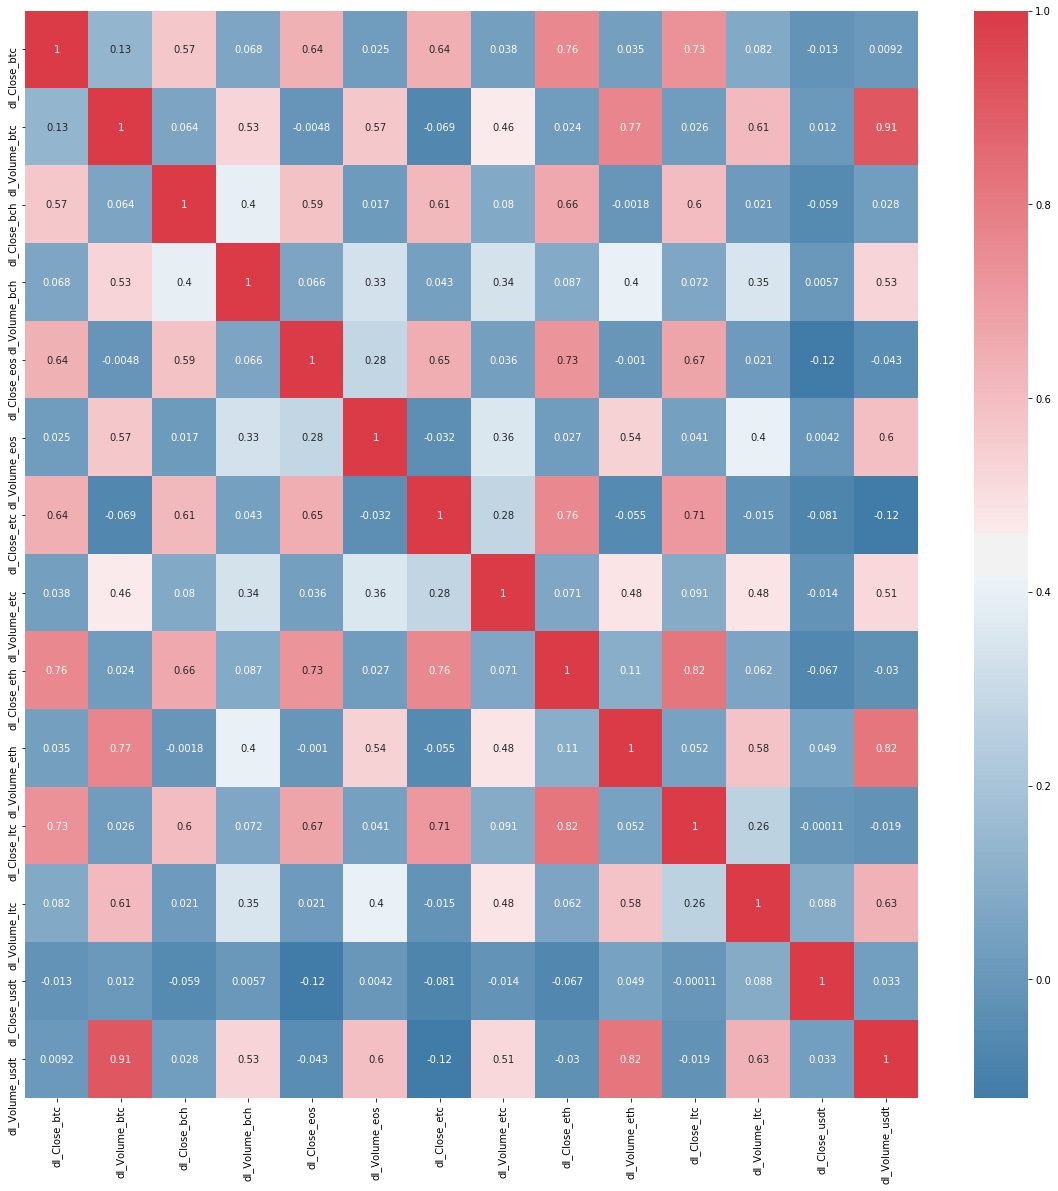

In [8]:
cmap = sns.diverging_palette(240, 10, as_cmap=True)
plt.figure(figsize=(20, 20))
sns.heatmap(r_df.corr(), cmap=cmap, annot=True)

From correlation matrix estimation we can assume linear relations between target variable and some predictors.

Ordinary linear regression was selected as a base line model.

In [9]:
# separate target variable from predictors
y = r_df["dl_Close_btc"]

# removing statistically not significant variables
# based on previos estimation and t-tests
x = r_df.drop(columns=["dl_Close_btc", "dl_Volume_etc", "dl_Close_etc", "dl_Close_bch", "dl_Volume_bch"])

x_test, y_test = x[-30:], y[-30:]
x, y = x[:-30], y[:-30]
    
model = OLS(y, x)
results = model.fit()
resids = results.resid.values
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           dl_Close_btc   R-squared (uncentered):                   0.694
Model:                            OLS   Adj. R-squared (uncentered):              0.691
Method:                 Least Squares   F-statistic:                              249.8
Date:                Wed, 05 Aug 2020   Prob (F-statistic):                   9.49e-248
Time:                        12:43:43   Log-Likelihood:                          2276.7
No. Observations:                1000   AIC:                                     -4535.
Df Residuals:                     991   BIC:                                     -4491.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
dl_Volume_btc      0.1238      0.009     13.195      0.000       0.105       0.142
dl_Close_eos       0.1174      0.019      6.066      0.000       0.079       0.155
dl_Volume_eos     -0.0168      0.004     -4.554      0.000      -0.024      -0.010
dl_Close_eth       0.3086      0.031      9.837      0.000       0.247       0.370
dl_Volume_eth     -0.0302      0.006     -4.969      0.000      -0.042      -0.018
dl_Close_ltc       0.2374      0.027      8.641      0.000       0.183       0.291
dl_Volume_ltc     -0.0159      0.004     -3.750      0.000      -0.024      -0.008
dl_Close_usdt      0.3784      0.127      2.979      0.003       0.129       0.628
dl_Volume_usdt    -0.0381      0.009     -4.425      0.000      -0.055      -0.021
==============================================================================
Omnibus:                      194.215   Durbin-Watson:                   1.823
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4467.667
Skew:                           0.161   Prob(JB):                         0.00
Kurtosis:                      13.350   Cond. No.                         78.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In estimated model all included variables are statistically significant at level of 1%. According to F-test model at all also sigificant. Adjusted $ R^2 $ is 0.691.

Next step is to analyze model residuals.

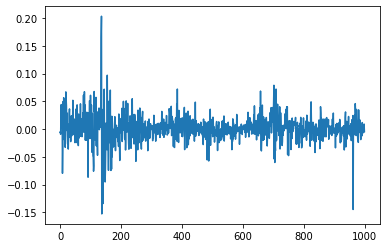

In [10]:
plt.plot(resids)

We can see that model residuals has constant mean.

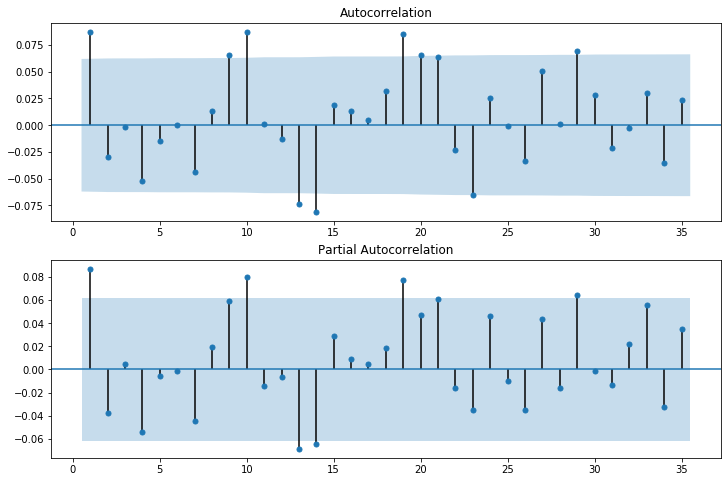

In [11]:
plot_autocorr(resids)

In [12]:
autocorrelation_tests(resids, 20)

,AC,Q,P-value
Lag,,,
1,0.086844,7.564565,0.005953
2,-0.030107,8.474601,0.014447
3,-0.001233,8.476129,0.037131
4,-0.051871,11.182984,0.024583
5,-0.015140,11.413828,0.043765
6,0.000327,11.413936,0.076395
7,-0.043568,13.329320,0.064480
8,0.013766,13.520724,0.095145
9,0.065249,17.825453,0.037253


According to autocorrelation plots and lag tests model residuals has autocorrelation in some lags (especially in first lag).

Jarque-Bera test:
 stat=4467.66665, p-value=0.00000

K-S test:
 stat=0.46728, p-value=0.00000


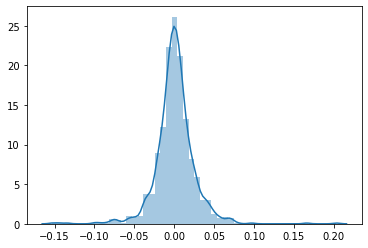

In [13]:
normality_tests(resids)

From normality tests and histogram plot we reject hypothesis of normally distributed model residuals.

According to residual analysis we should take into account residuals autocorrelation when chosing model. Next step is to include AR(p) terms into model. Estimate best model parametr by evaluating different specifications.

In [14]:
# this might take a while 
for i in range(21):
    res = ARMA(y, (i, 0), x).fit(method="css")
    print("ARMA(%d, 0): AIC=%.5f; BIC=%.5f" % (i, res.aic, res.bic))

ARMA(0, 0): AIC=-4533.15967; BIC=-4479.17436
ARMA(1, 0): AIC=-4534.00316; BIC=-4475.12211
ARMA(2, 0): AIC=-4528.24380; BIC=-4464.46901
ARMA(3, 0): AIC=-4520.85213; BIC=-4452.18562
ARMA(4, 0): AIC=-4517.88227; BIC=-4444.32606
ARMA(5, 0): AIC=-4513.27901; BIC=-4434.83512
ARMA(6, 0): AIC=-4505.86267; BIC=-4422.53314
ARMA(7, 0): AIC=-4500.56197; BIC=-4412.34881
ARMA(8, 0): AIC=-4494.31582; BIC=-4401.22108
ARMA(9, 0): AIC=-4502.52913; BIC=-4404.55484
ARMA(10, 0): AIC=-4502.41163; BIC=-4399.55982
ARMA(11, 0): AIC=-4499.46315; BIC=-4391.73587
ARMA(12, 0): AIC=-4491.94114; BIC=-4379.34044
ARMA(13, 0): AIC=-4493.08685; BIC=-4375.61477
ARMA(14, 0): AIC=-4491.08384; BIC=-4368.74243
ARMA(15, 0): AIC=-4485.11932; BIC=-4357.91063
ARMA(16, 0): AIC=-4478.76989; BIC=-4346.69599
ARMA(17, 0): AIC=-4471.56283; BIC=-4334.62577
ARMA(18, 0): AIC=-4465.12304; BIC=-4323.32489
ARMA(19, 0): AIC=-4466.62198; BIC=-4319.96481
ARMA(20, 0): AIC=-4468.09612; BIC=-4316.58199


According to information criterias best model is AR(1).

In [15]:
model = ARMA(y, (1, 0), x)
results = model.fit(method="css", trend="nc")
resids = results.resid.values
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           dl_Close_btc   No. Observations:                 1000
Model:                     ARMA(1, 0)   Log Likelihood                2278.308
Method:                           css   S.D. of innovations              0.025
Date:                Wed, 05 Aug 2020   AIC                          -4534.616
Time:                        12:44:24   BIC                          -4480.641
Sample:                             1   HQIC                         -4514.101
                                                                              
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
dl_Volume_btc          0.1174      0.009     12.588      0.000       0.099       0.136
dl_Close_eos           0.1086      0.019      5.614      0.000       0.071       0.146
dl_Volume_eos         -0.0163      0.004     -4.573      0.000      -0.023      -0.009
dl_Close_eth           0.3139      0.031     10.028      0.000       0.253       0.375
dl_Volume_eth         -0.0287      0.006     -4.859      0.000      -0.040      -0.017
dl_Close_ltc           0.2440      0.027      8.909      0.000       0.190       0.298
dl_Volume_ltc         -0.0162      0.004     -3.936      0.000      -0.024      -0.008
dl_Close_usdt          0.3497      0.121      2.891      0.004       0.113       0.587
dl_Volume_usdt        -0.0348      0.008     -4.149      0.000      -0.051      -0.018
ar.L1.dl_Close_btc     0.0972      0.033      2.951      0.003       0.033       0.162
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           10.2932           +0.0000j           10.2932            0.0000
-----------------------------------------------------------------------------
"""

All model parameters are statistically significant at level of 1%. AR process dont have unit root.

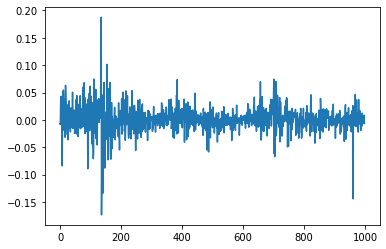

In [16]:
plt.plot(resids)

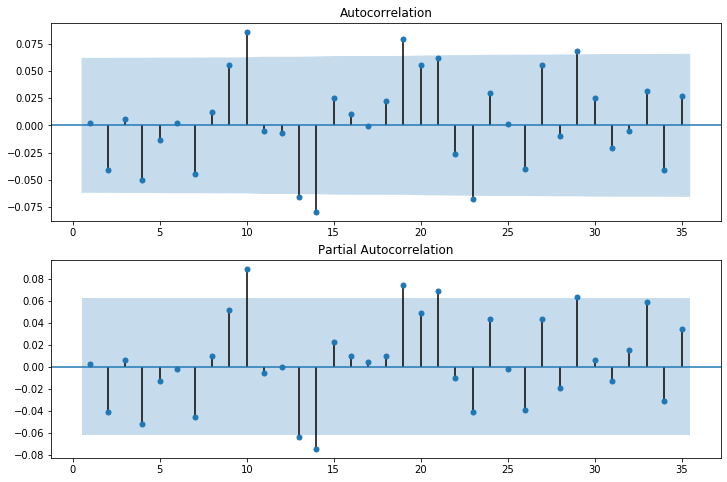

In [17]:
plot_autocorr(resids)

In [18]:
autocorrelation_tests(resids, 20)

,AC,Q,P-value
Lag,,,
1,0.002366,0.005608,0.940302
2,-0.041062,1.696781,0.428103
3,0.005937,1.732173,0.629805
4,-0.049972,4.241881,0.374259
5,-0.013144,4.415682,0.491244
6,0.002157,4.420368,0.619984
7,-0.044816,6.445029,0.488849
8,0.012291,6.597460,0.580619
9,0.055874,9.750950,0.371021


Jarque-Bera test:
 stat=4262.08075, p-value=0.00000

K-S test:
 stat=0.46723, p-value=0.00000


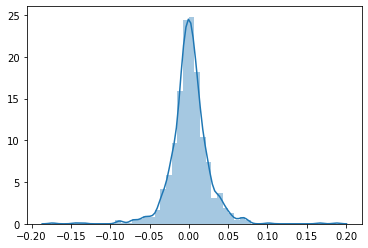

In [19]:
normality_tests(resids)

From model residuals analysis we can see that residuals have constant mean as in previous model. Also this model was able to partly solve autocorrelation problem. Now we dont observ significant autocorrelation up to 14 lag. Still residuals dont follow normal distribution.

Next step is to forecast logarithmic returns of BTC Close price up to 30 days.

Forecast:
  RMSE=0.018771; STD Error=0.017374


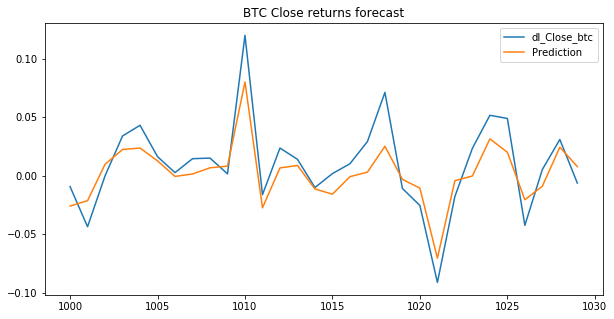

In [20]:
pred = results.predict(x_test.index[0], x_test.index[-1], exog=x_test, dynamic=True)

plt.figure(figsize=(10, 5))
plt.plot(y_test, label="dl_Close_btc")
plt.plot(pred, label="Prediction")
plt.title("BTC Close returns forecast")
plt.legend()

print("Forecast:\n  RMSE=%.6f; STD Error=%.6f" % (rmse(y_test, pred), stde(y_test, pred)))

To move from logarithmic returns to prices used:
\begin{equation*}
x_t = x_{t-1}e^{r_t}.
\end{equation*}

Exponential smoothing was used to distinguish trend from forecast.

Forecast:
  RMSE=0.018771; STD Error=0.017374


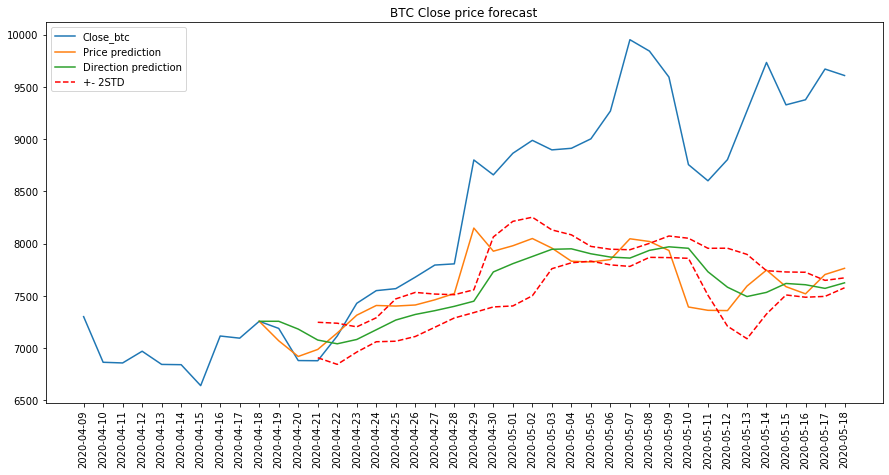

In [21]:
price_forecast = [btc_price[-31]]
for r in pred:
    price_forecast.append(price_forecast[-1] * np.exp(r))
price_forecast = pd.Series(price_forecast, index=btc_price.index[-31:])


res = SimpleExpSmoothing(price_forecast).fit(smoothing_level=0.4,optimized=False)
forecast = res.predict(price_forecast.index[0], price_forecast.index[-1])
forecast = pd.Series(forecast, index=price_forecast.index)

std = forecast.rolling(4).std()
plt.figure(figsize=(15, 7))
plt.plot(btc_price[-40:], label="Close_btc")
plt.plot(price_forecast, label="Price prediction")
plt.plot(forecast, label="Direction prediction")
plt.plot(forecast + 2*std, 'r--', label="+- 2STD")
plt.plot(forecast - 2*std, 'r--')
plt.xticks(rotation=90)
plt.title("BTC Close price forecast")
plt.legend()

print("Forecast:\n  RMSE=%.6f; STD Error=%.6f" % (rmse(y_test, pred), stde(y_test, pred)))

From forecast chart we can see that general BTC Close price movement was guesed right. Forecasted price was accurated for first 12 days.